In [1]:
from torchvision import datasets, transforms
from pathlib import Path

In [2]:
aug_transforms = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
])

In [3]:
data_path = "../data-unversioned/p1ch7/"
download = not Path(data_path).exists()
cifar10 = datasets.CIFAR10(data_path, train=True, 
                           transform=aug_transforms, download=download)
cifar10_val = datasets.CIFAR10(data_path, train=False, 
                               transform=transforms.ToTensor(), download=download)

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [ (img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [ (img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

## 데이터 확인

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np

In [6]:
airplane_ix, bird_ix = None, None
for ix in range(len(cifar2)):
    _, label = cifar2[ix]
    if label == 0:
        airplane_ix = ix
    elif label == 1:
        bird_ix = ix
    
    if (airplane_ix is not None) and (bird_ix is not None):
        break
        
print(f"Airplane index: {airplane_ix}, Bird index: {bird_ix}")

Airplane index: 4, Bird index: 3


Text(0.5, 1.0, 'bird')

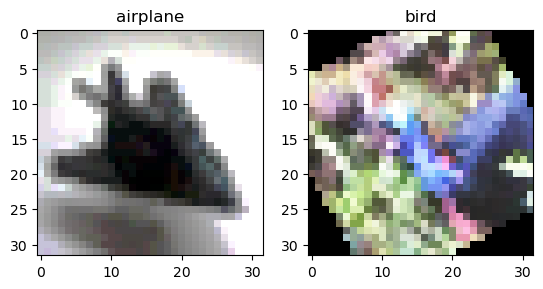

In [7]:
plt.subplot(121)
img, label = cifar2[airplane_ix]
plt.imshow(img.permute(1,2,0)); plt.title('airplane')
plt.subplot(122)
img, label = cifar2[bird_ix]
plt.imshow(img.permute(1,2,0)); plt.title('bird')

## Model

In [8]:
import torch.nn as nn

In [9]:
n_out = 2

model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

## Softmax

In [10]:
def softmax(x):
    return x.exp() / x.exp().sum()

x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [11]:
softmax(x).sum()

tensor(1.)

In [12]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
                 [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [13]:
softmax(x).sum(1)

tensor([1., 1.])

## Model with softmax

In [14]:
model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

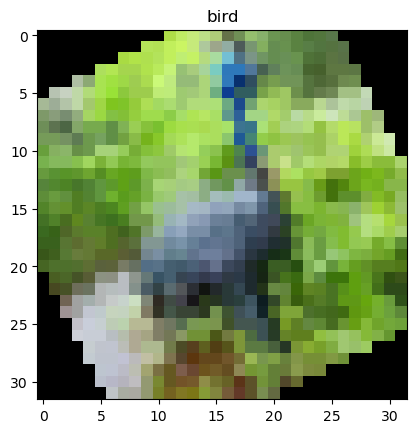

In [15]:
img, label = cifar2[0]

plt.imshow(img.permute(1,2,0)); plt.title(class_names[label]); plt.show()

In [16]:
img_batch = img.view(-1).unsqueeze(0)


In [17]:
out = model(img_batch)
out

tensor([[0.4452, 0.5548]], grad_fn=<SoftmaxBackward0>)

In [18]:
_, index = torch.max(out, dim=1)
class_names[index.item()]

'bird'

## Model compatible with `NLLLoss`

In [19]:
model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.LogSoftmax(dim=1)
)

In [20]:
loss = nn.NLLLoss()

In [21]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.5489, grad_fn=<NllLossBackward0>)

## Training

In [22]:
import torch

# Check if GPU is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
device = torch.device("cpu")

In [23]:
model.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)

In [24]:
lr = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        img = img.to(device)
        label_t = torch.tensor([label]).to(device)
        
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, label_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 0.5664
Epoch: 1, Loss: 0.6661
Epoch: 2, Loss: 0.7196
Epoch: 3, Loss: 0.8176
Epoch: 4, Loss: 1.1851
Epoch: 5, Loss: 0.8232
Epoch: 6, Loss: 1.5504
Epoch: 7, Loss: 1.6449
Epoch: 8, Loss: 1.9776
Epoch: 9, Loss: 2.4918
Epoch: 10, Loss: 2.1499
Epoch: 11, Loss: 0.7769
Epoch: 12, Loss: 3.9429
Epoch: 13, Loss: 5.1815
Epoch: 14, Loss: 2.2081
Epoch: 15, Loss: 3.9928
Epoch: 16, Loss: 4.4473
Epoch: 17, Loss: 5.7964
Epoch: 18, Loss: 2.3371
Epoch: 19, Loss: 0.1455
Epoch: 20, Loss: 3.5052
Epoch: 21, Loss: 8.2367
Epoch: 22, Loss: 3.9881
Epoch: 23, Loss: 4.6422
Epoch: 24, Loss: 2.4333
Epoch: 25, Loss: 4.7288
Epoch: 26, Loss: 10.9496
Epoch: 27, Loss: 6.2192
Epoch: 28, Loss: 4.5911
Epoch: 29, Loss: 6.9770
Epoch: 30, Loss: 2.1342
Epoch: 31, Loss: 4.2715
Epoch: 32, Loss: 1.9302
Epoch: 33, Loss: 3.0932
Epoch: 34, Loss: 0.3521
Epoch: 35, Loss: 0.0403
Epoch: 36, Loss: 1.4676
Epoch: 37, Loss: 8.2515
Epoch: 38, Loss: 3.0102
Epoch: 39, Loss: 7.2635
Epoch: 40, Loss: 2.2317
Epoch: 41, Loss: 3.3419
E

## Use dataloader for batched inputs

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

lr = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        img = img.to(device)
        label_t = label.to(device)
        batch_size = img.shape[0]
        
        out = model(img.view(batch_size, -1))
        loss = loss_fn(out, label_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 0.7449
Epoch: 1, Loss: 0.8439
Epoch: 2, Loss: 0.6642
Epoch: 3, Loss: 0.5224
Epoch: 4, Loss: 0.4563
Epoch: 5, Loss: 0.6982
Epoch: 6, Loss: 0.5782
Epoch: 7, Loss: 0.6113
Epoch: 8, Loss: 0.9916
Epoch: 9, Loss: 0.9982
Epoch: 10, Loss: 0.8784
Epoch: 11, Loss: 0.6609
Epoch: 12, Loss: 0.7115
Epoch: 13, Loss: 0.7566
Epoch: 14, Loss: 0.6332
Epoch: 15, Loss: 0.2595
Epoch: 16, Loss: 0.6878
Epoch: 17, Loss: 0.4097
Epoch: 18, Loss: 0.8018
Epoch: 19, Loss: 0.3940
Epoch: 20, Loss: 0.5327
Epoch: 21, Loss: 1.0153
Epoch: 22, Loss: 0.5081
Epoch: 23, Loss: 0.6180
Epoch: 24, Loss: 0.6106
Epoch: 25, Loss: 0.5061
Epoch: 26, Loss: 0.6632
Epoch: 27, Loss: 0.6283
Epoch: 28, Loss: 0.6238
Epoch: 29, Loss: 0.1312
Epoch: 30, Loss: 0.5555
Epoch: 31, Loss: 0.9666
Epoch: 32, Loss: 0.9071
Epoch: 33, Loss: 0.6794
Epoch: 34, Loss: 0.7907
Epoch: 35, Loss: 0.5724
Epoch: 36, Loss: 0.6551
Epoch: 37, Loss: 0.9139
Epoch: 38, Loss: 0.7518
Epoch: 39, Loss: 0.9561
Epoch: 40, Loss: 1.0038
Epoch: 41, Loss: 0.6367
Ep

## Evaluate

In [26]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy : ", correct / total)

Accuracy :  0.7725


In [27]:
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)

## Deeper network

`CrossEntropyLoss`를 사용하면 output layer에서 `LogSoftmax` activation을 사용하지 않아도 된다

In [28]:
model = nn.Sequential(
    nn.Linear(32*32*3, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, n_out)
).to(device)

In [29]:
loss_fn = nn.CrossEntropyLoss() # loss_fn을 nn.CrossEntropyLoss를 사용

## Training the deeper model with CE loss

In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

lr = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        img = img.to(device)
        label_t = label.to(device)
        batch_size = img.shape[0]
        
        out = model(img.view(batch_size, -1))
        loss = loss_fn(out, label_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 0.6824
Epoch: 1, Loss: 0.6108
Epoch: 2, Loss: 0.5956
Epoch: 3, Loss: 0.6539
Epoch: 4, Loss: 0.6186
Epoch: 5, Loss: 0.6931
Epoch: 6, Loss: 0.5484
Epoch: 7, Loss: 0.7021
Epoch: 8, Loss: 0.6365
Epoch: 9, Loss: 0.7070
Epoch: 10, Loss: 0.7656
Epoch: 11, Loss: 0.5924
Epoch: 12, Loss: 0.5805
Epoch: 13, Loss: 0.6291
Epoch: 14, Loss: 0.6035
Epoch: 15, Loss: 0.7274
Epoch: 16, Loss: 0.6117
Epoch: 17, Loss: 0.7066
Epoch: 18, Loss: 0.5106
Epoch: 19, Loss: 0.8527
Epoch: 20, Loss: 0.6843
Epoch: 21, Loss: 0.5869
Epoch: 22, Loss: 0.5029
Epoch: 23, Loss: 0.5988
Epoch: 24, Loss: 0.5773
Epoch: 25, Loss: 0.8829
Epoch: 26, Loss: 0.4868
Epoch: 27, Loss: 0.4948
Epoch: 28, Loss: 0.4139
Epoch: 29, Loss: 0.6001
Epoch: 30, Loss: 0.5553
Epoch: 31, Loss: 0.4304
Epoch: 32, Loss: 0.4131
Epoch: 33, Loss: 0.5504
Epoch: 34, Loss: 0.5835
Epoch: 35, Loss: 0.5182
Epoch: 36, Loss: 0.4280
Epoch: 37, Loss: 0.5393
Epoch: 38, Loss: 0.4735
Epoch: 39, Loss: 0.5679
Epoch: 40, Loss: 0.4396
Epoch: 41, Loss: 0.5761
Ep

## Evaluate

In [31]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy : ", correct / total)

Accuracy :  0.81
